In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [7]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [8]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [9]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [10]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [11]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [12]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [13]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

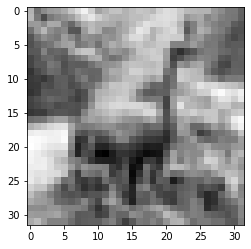

In [14]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

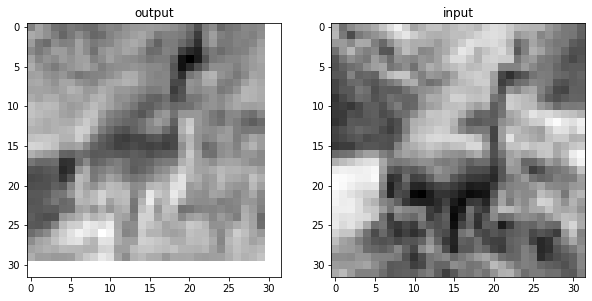

In [15]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [17]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

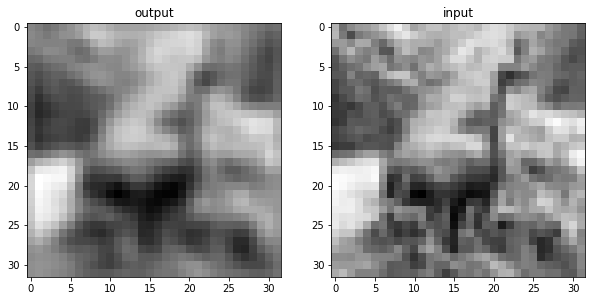

In [18]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [19]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

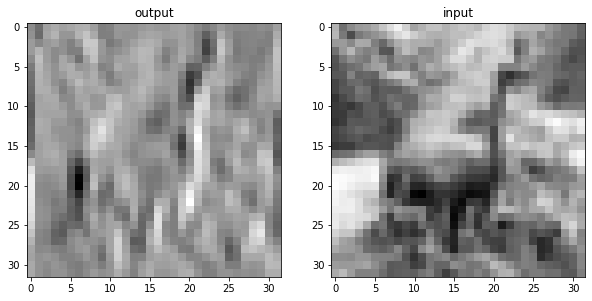

In [20]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [21]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [22]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [23]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8*8*8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [24]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [25]:
model(img.unsqueeze(0))

RuntimeError: ignored

In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [28]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [29]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward0>)

In [30]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [31]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-03-29 02:11:38.668115 Epoch 1, Training loss 0.56404867939129
2022-03-29 02:12:07.911882 Epoch 10, Training loss 0.32760468742270377
2022-03-29 02:12:41.129855 Epoch 20, Training loss 0.30307469284458527
2022-03-29 02:13:13.225257 Epoch 30, Training loss 0.28098370514477894
2022-03-29 02:13:45.401042 Epoch 40, Training loss 0.26119488620074693
2022-03-29 02:14:17.439695 Epoch 50, Training loss 0.24396828690152259
2022-03-29 02:14:49.973136 Epoch 60, Training loss 0.22478416324800746
2022-03-29 02:15:22.499349 Epoch 70, Training loss 0.2053464343593379
2022-03-29 02:15:54.677986 Epoch 80, Training loss 0.18890236574373429
2022-03-29 02:16:26.881042 Epoch 90, Training loss 0.17473488685431754
2022-03-29 02:16:59.420934 Epoch 100, Training loss 0.1615173067351815
2022-03-29 02:17:31.806954 Epoch 110, Training loss 0.14524311744341045
2022-03-29 02:18:04.451547 Epoch 120, Training loss 0.13300598507664005
2022-03-29 02:18:36.979059 Epoch 130, Training loss 0.11950130518644479
2022-03-

In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.89


In [33]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [34]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [35]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [36]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-03-29 02:28:00.126971 Epoch 1, Training loss 0.5545350671953456
2022-03-29 02:28:03.140042 Epoch 10, Training loss 0.3355646601338295
2022-03-29 02:28:06.468701 Epoch 20, Training loss 0.2981623767098044
2022-03-29 02:28:09.800243 Epoch 30, Training loss 0.2733079117194862
2022-03-29 02:28:13.199742 Epoch 40, Training loss 0.2508797823528575
2022-03-29 02:28:16.548718 Epoch 50, Training loss 0.23094660001006095
2022-03-29 02:28:19.879761 Epoch 60, Training loss 0.2157911510224555
2022-03-29 02:28:23.197417 Epoch 70, Training loss 0.1975332770947438
2022-03-29 02:28:26.529849 Epoch 80, Training loss 0.1850810708703509
2022-03-29 02:28:29.857950 Epoch 90, Training loss 0.17067694277235657
2022-03-29 02:28:33.207741 Epoch 100, Training loss 0.15803915888640532
2022-03-29 02:28:36.542637 Epoch 110, Training loss 0.1442497689632853
2022-03-29 02:28:39.874513 Epoch 120, Training loss 0.1310235186936749
2022-03-29 02:28:43.256452 Epoch 130, Training loss 0.12145964101336565
2022-03-29 02

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.89


In [39]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

In [40]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [41]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2022-03-29 02:29:40.894469 Epoch 1, Training loss 0.5269006758358827
2022-03-29 02:29:44.064087 Epoch 10, Training loss 0.3113905039562541
2022-03-29 02:29:47.575764 Epoch 20, Training loss 0.27048281100904864
2022-03-29 02:29:51.074645 Epoch 30, Training loss 0.23893570235580397
2022-03-29 02:29:54.555172 Epoch 40, Training loss 0.21049665393912867
2022-03-29 02:29:58.064686 Epoch 50, Training loss 0.18524652657804974
2022-03-29 02:30:01.588246 Epoch 60, Training loss 0.16191510908353102
2022-03-29 02:30:05.078356 Epoch 70, Training loss 0.13993723875587913
2022-03-29 02:30:08.543337 Epoch 80, Training loss 0.11917547345351262
2022-03-29 02:30:12.021610 Epoch 90, Training loss 0.10014414737463757
2022-03-29 02:30:15.479912 Epoch 100, Training loss 0.08330724893766604
2022-03-29 02:30:18.982972 Epoch 110, Training loss 0.06862964335188365
2022-03-29 02:30:22.440744 Epoch 120, Training loss 0.056203826644997686
2022-03-29 02:30:25.941588 Epoch 130, Training loss 0.046004463983759
2022-0

{'train': 0.9998, 'val': 0.895}

In [42]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [43]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-03-29 02:31:25.734093 Epoch 1, Training loss 0.5428723022816287
2022-03-29 02:31:28.910582 Epoch 10, Training loss 0.31507463402049557
2022-03-29 02:31:32.390900 Epoch 20, Training loss 0.274491908538873
2022-03-29 02:31:35.852289 Epoch 30, Training loss 0.2420541369326555
2022-03-29 02:31:39.354939 Epoch 40, Training loss 0.21310327624439435
2022-03-29 02:31:42.822095 Epoch 50, Training loss 0.18815770308682872
2022-03-29 02:31:46.324407 Epoch 60, Training loss 0.1657214085482488
2022-03-29 02:31:49.826117 Epoch 70, Training loss 0.14454565814156442
2022-03-29 02:31:53.358026 Epoch 80, Training loss 0.12422453946653444
2022-03-29 02:31:56.795708 Epoch 90, Training loss 0.10498238200689577
2022-03-29 02:32:00.323352 Epoch 100, Training loss 0.08738079846237495
2022-03-29 02:32:03.785705 Epoch 110, Training loss 0.07180094123361216
2022-03-29 02:32:07.241313 Epoch 120, Training loss 0.058650180602529245
2022-03-29 02:32:10.693008 Epoch 130, Training loss 0.04794660910584365
2022-03

In [44]:
sum(p.numel() for p in model.parameters())

38386

In [45]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [46]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-03-29 02:33:10.510904 Epoch 1, Training loss 0.5783085821160845
2022-03-29 02:33:14.481130 Epoch 10, Training loss 0.3548936802110854
2022-03-29 02:33:18.891208 Epoch 20, Training loss 0.3233899992362709
2022-03-29 02:33:23.274864 Epoch 30, Training loss 0.3023214055474397
2022-03-29 02:33:27.692702 Epoch 40, Training loss 0.2840828125833706
2022-03-29 02:33:32.073610 Epoch 50, Training loss 0.26798569548661544
2022-03-29 02:33:36.450531 Epoch 60, Training loss 0.25304466837151035
2022-03-29 02:33:40.899081 Epoch 70, Training loss 0.2395798883810165
2022-03-29 02:33:45.318755 Epoch 80, Training loss 0.22796343622883414
2022-03-29 02:33:49.720189 Epoch 90, Training loss 0.2173463120866733
2022-03-29 02:33:54.109611 Epoch 100, Training loss 0.2075545919264198
2022-03-29 02:33:58.485989 Epoch 110, Training loss 0.19827784384322014
2022-03-29 02:34:02.940467 Epoch 120, Training loss 0.1895417574389725
2022-03-29 02:34:07.352411 Epoch 130, Training loss 0.18136066136656293
2022-03-29 0

In [47]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [48]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-03-29 02:35:22.981325 Epoch 1, Training loss 0.5671973742876842
2022-03-29 02:35:26.355360 Epoch 10, Training loss 0.37656499046808595
2022-03-29 02:35:30.090749 Epoch 20, Training loss 0.3513412181359188
2022-03-29 02:35:33.825331 Epoch 30, Training loss 0.3349655071261582
2022-03-29 02:35:37.610133 Epoch 40, Training loss 0.31586770561470345
2022-03-29 02:35:41.317250 Epoch 50, Training loss 0.301499041971887
2022-03-29 02:35:45.017014 Epoch 60, Training loss 0.2827965340986373
2022-03-29 02:35:48.730470 Epoch 70, Training loss 0.2742137172419554
2022-03-29 02:35:52.393848 Epoch 80, Training loss 0.2633539180087436
2022-03-29 02:35:56.121422 Epoch 90, Training loss 0.2546058789749814
2022-03-29 02:35:59.846526 Epoch 100, Training loss 0.24389921560598787
2022-03-29 02:36:03.547470 Epoch 110, Training loss 0.23518212092150548
2022-03-29 02:36:07.269633 Epoch 120, Training loss 0.2224484450023645
2022-03-29 02:36:10.959575 Epoch 130, Training loss 0.2152044645445362
2022-03-29 02:

In [49]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [50]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-03-29 02:37:14.418427 Epoch 1, Training loss 0.48404647723125044
2022-03-29 02:37:18.135015 Epoch 10, Training loss 0.2821384605708396
2022-03-29 02:37:22.219580 Epoch 20, Training loss 0.2195448674214114
2022-03-29 02:37:26.298228 Epoch 30, Training loss 0.16772914630402425
2022-03-29 02:37:30.391645 Epoch 40, Training loss 0.12147538060215628
2022-03-29 02:37:34.471916 Epoch 50, Training loss 0.08157631741824803
2022-03-29 02:37:38.583324 Epoch 60, Training loss 0.05286126477038784
2022-03-29 02:37:42.731737 Epoch 70, Training loss 0.03345049751602161
2022-03-29 02:37:46.788908 Epoch 80, Training loss 0.026648235394601608
2022-03-29 02:37:50.896391 Epoch 90, Training loss 0.01371867357824401
2022-03-29 02:37:54.968618 Epoch 100, Training loss 0.009110698971754996
2022-03-29 02:37:59.072740 Epoch 110, Training loss 0.006494275177087469
2022-03-29 02:38:03.183360 Epoch 120, Training loss 0.004837285708725025
2022-03-29 02:38:07.233325 Epoch 130, Training loss 0.003709361214445797


In [51]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [52]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2022-03-29 02:39:17.440564 Epoch 1, Training loss 0.6800243353388112
2022-03-29 02:39:21.146720 Epoch 10, Training loss 0.33850326251452134
2022-03-29 02:39:25.233962 Epoch 20, Training loss 0.29920581467212387
2022-03-29 02:39:29.310226 Epoch 30, Training loss 0.27215479997692593
2022-03-29 02:39:33.366481 Epoch 40, Training loss 0.24412665321568774
2022-03-29 02:39:37.441531 Epoch 50, Training loss 0.21377775049323489
2022-03-29 02:39:41.557897 Epoch 60, Training loss 0.1860504491598743
2022-03-29 02:39:45.662059 Epoch 70, Training loss 0.16021040008421156
2022-03-29 02:39:49.777955 Epoch 80, Training loss 0.1351161804168847
2022-03-29 02:39:53.843416 Epoch 90, Training loss 0.11044551586364484
2022-03-29 02:39:57.908238 Epoch 100, Training loss 0.08735343208239907
2022-03-29 02:40:02.003361 Epoch 110, Training loss 0.06613153000332557
2022-03-29 02:40:06.082578 Epoch 120, Training loss 0.050941558287828974
2022-03-29 02:40:10.174753 Epoch 130, Training loss 0.033106352887739235
2022

In [53]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-03-29 02:41:20.426671 Epoch 1, Training loss 0.6244431515787817
2022-03-29 02:41:24.150613 Epoch 10, Training loss 0.3267557407450524
2022-03-29 02:41:28.337126 Epoch 20, Training loss 0.28386498608027294
2022-03-29 02:41:32.436340 Epoch 30, Training loss 0.25069867444645827
2022-03-29 02:41:36.546177 Epoch 40, Training loss 0.22155869182697527
2022-03-29 02:41:40.667037 Epoch 50, Training loss 0.19694264237857928
2022-03-29 02:41:44.870184 Epoch 60, Training loss 0.17343679547404786
2022-03-29 02:41:49.029317 Epoch 70, Training loss 0.14965808206492928
2022-03-29 02:41:53.138811 Epoch 80, Training loss 0.12641168033383834
2022-03-29 02:41:57.235487 Epoch 90, Training loss 0.10233845243788069
2022-03-29 02:42:01.346344 Epoch 100, Training loss 0.08218617078842251
2022-03-29 02:42:05.459384 Epoch 110, Training loss 0.07216908843820072
2022-03-29 02:42:09.572161 Epoch 120, Training loss 0.061097737988990965
2022-03-29 02:42:13.784058 Epoch 130, Training loss 0.10518323159391049
2022

In [55]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [56]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    


In [57]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-03-29 02:43:32.542271 Epoch 1, Training loss 1.1697108529175921
2022-03-29 02:44:44.447013 Epoch 10, Training loss 0.3066888057692036
2022-03-29 02:46:04.272900 Epoch 20, Training loss 0.23126005927088913
2022-03-29 02:47:24.289842 Epoch 30, Training loss 0.1584680263593698
2022-03-29 02:48:44.216673 Epoch 40, Training loss 0.139297266152634
2022-03-29 02:50:04.284224 Epoch 50, Training loss 0.11357576006157383
2022-03-29 02:51:24.360254 Epoch 60, Training loss 0.10315748117270933
2022-03-29 02:52:44.471436 Epoch 70, Training loss 0.18076486047950518
2022-03-29 02:54:04.473965 Epoch 80, Training loss 0.17588084271758986
2022-03-29 02:55:24.600009 Epoch 90, Training loss 0.13327897061255706
2022-03-29 02:56:44.575833 Epoch 100, Training loss 0.07760448764066455
2022-03-29 02:58:04.686085 Epoch 110, Training loss 0.04136423167630223
2022-03-29 02:59:24.814936 Epoch 120, Training loss 0.0755727422330232
2022-03-29 03:00:44.703817 Epoch 130, Training loss 0.05119188138887926
2022-03-2

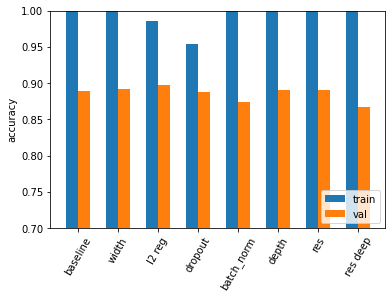

In [58]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()
